# Federated Learning: Train FL Model in Python

In the "Part 01 - Create Plan" notebooks we created the model, training plan, and averaging plan, and then hosted all of them in PyGrid.

Such hosted FL model can be now trained using client libraries, SwiftSyft, KotlinSyft, syft.js.

In this notebook, we'll use FL Client included in the PySyft to do the training.

In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings("ignore")

import torch as th
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

import syft as sy
from syft.federated.fl_client import FLClient
from syft.federated.fl_job import FLJob
from syft.grid.clients.static_fl_client import StaticFLClient

sy.make_hook(globals())

Setting up Sandbox...
Done!


Define `on_accepted`, `on_rejected`, `on_error` handlers.

The main training loop is located inside `on_accepted` routine.

In [2]:
cycles_log = []
status = {
    "ended": False
}

# Called when client is accepted into FL cycle
def on_accepted(job: FLJob):
    print(f"Accepted into cycle {len(cycles_log) + 1}!")

    cycle_params = job.client_config
    batch_size = cycle_params["batch_size"]
    lr = cycle_params["lr"]
    max_updates = cycle_params["max_updates"]

    mnist_dataset = th.utils.data.DataLoader(
        datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor()),
        batch_size=batch_size,
        drop_last=True,
        shuffle=True,
    )

    training_plan = job.plans["training_plan"]
    model_params = job.model.tensors()
    losses = []
    accuracies = []

    for batch_idx, (X, y) in enumerate(mnist_dataset):
        X = X.view(batch_size, -1)
        y_oh = th.nn.functional.one_hot(y, 10)
        loss, acc, *model_params = training_plan.torchscript(
            X, y_oh, th.tensor(batch_size), th.tensor(lr), model_params
        )
        losses.append(loss.item())
        accuracies.append(acc.item())
        if batch_idx % 50 == 0:
            print("Batch %d, loss: %f, accuracy: %f" % (batch_idx, loss, acc))
        if batch_idx >= max_updates:
            break

    job.report(model_params)
    # Save losses/accuracies from cycle
    cycles_log.append((losses, accuracies))

# Called when the client is rejected from cycle
def on_rejected(job: FLJob, timeout):
    if timeout is None:
        print(f"Rejected from cycle without timeout (this means FL training is done)")
    else:
        print(f"Rejected from cycle with timeout: {timeout}")
    status["ended"] = True

# Called when error occured
def on_error(job: FLJob, error: Exception):
    print(f"Error: {error}")
    status["ended"] = True

Here we have model gateway address, model name/version,
and define routine that creates FL client and starts the FL process.

In [3]:
# Default pygrid gateway address when running locally
gatewayWsUrl = "ws://127.0.0.1:5000"

# Hosted model
model_name = "mnist"
model_version = "1.0.0"

def create_client_and_run_cycle():
    client = FLClient(url=gatewayWsUrl, auth_token="", verbose=True)
    job = client.new_job(model_name, model_version)

    # Set event handlers
    job.add_listener(job.EVENT_ACCEPTED, on_accepted)
    job.add_listener(job.EVENT_REJECTED, on_rejected)
    job.add_listener(job.EVENT_ERROR, on_error)

    # Shoot!
    job.start()


Now we're ready to start FL training.

We're going to run multiple cycles until the FL model is fully done and see the progress.

As we create & authenticate new client each time,
this emulates multiple different workers requesting a cycle and working on it.

Total number of cycles is going to be `max_diffs` times `num_cycles` as set in the server config in "Host Plan" notebook. 

In [4]:
while not status["ended"]:
    create_client_and_run_cycle()

Accepted into cycle 1!
Batch 0, loss: 2.292947, accuracy: 0.109375
Batch 50, loss: 2.239735, accuracy: 0.390625
Batch 100, loss: 2.190737, accuracy: 0.453125
Accepted into cycle 2!
Batch 0, loss: 2.293502, accuracy: 0.203125
Batch 50, loss: 2.229298, accuracy: 0.406250
Batch 100, loss: 2.211985, accuracy: 0.359375
Accepted into cycle 3!
Batch 0, loss: 2.289004, accuracy: 0.187500
Batch 50, loss: 2.238803, accuracy: 0.375000
Batch 100, loss: 2.182254, accuracy: 0.578125
Accepted into cycle 4!
Batch 0, loss: 2.289222, accuracy: 0.109375
Batch 50, loss: 2.237057, accuracy: 0.359375
Batch 100, loss: 2.186597, accuracy: 0.546875
Accepted into cycle 5!
Batch 0, loss: 2.292509, accuracy: 0.109375
Batch 50, loss: 2.261053, accuracy: 0.218750
Batch 100, loss: 2.178303, accuracy: 0.546875
Accepted into cycle 6!
Batch 0, loss: 2.304243, accuracy: 0.078125
Batch 50, loss: 2.245826, accuracy: 0.390625
Batch 100, loss: 2.192046, accuracy: 0.546875
Accepted into cycle 7!
Batch 0, loss: 2.288948, accu

GridError: ('(sqlite3.OperationalError) database is locked\n(Background on this error at: http://sqlalche.me/e/e3q8)', None)

Let's plot loss and accuracy statistics recorded from each client/cycle.
Each such cycle is drawn with different color.

It's visible that loss/accuracy improvement occurs after each 3 cycles,
because pygrid updates the model and creates new checkpoint after
receiving 3 updates from FL clients (this is controlled by `max_workers` parameter).

Cycle 1:	Loss: 2.2441309230162365	Acc: 0.30383663366336633
Cycle 2:	Loss: 2.2438044406399866	Acc: 0.3001237623762376
Cycle 3:	Loss: 2.2418281654320142	Acc: 0.29548267326732675
Cycle 4:	Loss: 2.1312978196852277	Acc: 0.5603341584158416
Cycle 5:	Loss: 2.133360725818294	Acc: 0.5606435643564357
Cycle 6:	Loss: 2.1304631540090733	Acc: 0.5716274752475248
Cycle 7:	Loss: 2.0016671702413276	Acc: 0.6573329207920792
Cycle 8:	Loss: 1.9960909798593804	Acc: 0.6585705445544554
Cycle 9:	Loss: 2.0072728891183833	Acc: 0.6599628712871287
Cycle 10:	Loss: 1.849586595403086	Acc: 0.7122524752475248
Cycle 11:	Loss: 1.8407292354224931	Acc: 0.7069925742574258
Cycle 12:	Loss: 1.8476795524653822	Acc: 0.698174504950495
Cycle 13:	Loss: 1.6817169460919823	Acc: 0.7286509900990099
Cycle 14:	Loss: 1.6831473112106323	Acc: 0.7295792079207921
Cycle 15:	Loss: 1.6826422344339955	Acc: 0.7235457920792079


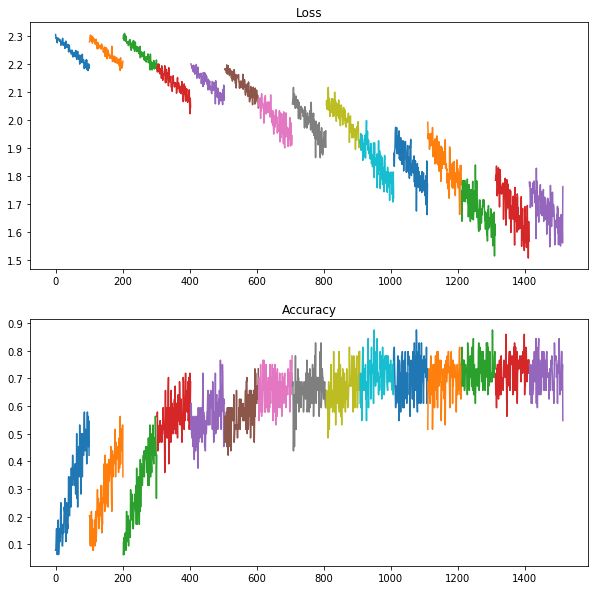

In [15]:
fig, axs = plt.subplots(2, figsize=(10, 10))
axs[0].set_title("Loss")
axs[1].set_title("Accuracy")
offset = 0
for i, cycle_log in enumerate(cycles_log):
    losses, accuracies = cycle_log
    x = range(offset, offset + len(losses))
    axs[0].plot(x, losses)
    axs[1].plot(x, accuracies)
    offset += len(losses)
    print(f"Cycle {i + 1}:\tLoss: {np.mean(losses)}\tAcc: {np.mean(accuracies)}")